# INSTRUCTIONS:
1) Generate tuples using AllenNLP

2) Call create_id_files

3) Run Train_TransE

4) Call reduce_relations

In [9]:
import numpy as np
import json
import matplotlib.pyplot as plt

In [20]:
def get_ids(idfile):
    with open(idfile, 'r') as infile:
        lines = infile.read().split('\n')[:-1]
        ilist = [''] * len(lines)
        for pair in lines:
            p = pair.split('\t')
            ilist[int(p[1])] = p[0]
    return ilist
    
def get_vectors(vecfile):
    with open(vecfile, 'r') as infile:
        lines = infile.read().split('\n')[:-1]
        vlist = [np.array([float(s) for s in vec.split('\t') if len(s) > 0]) for vec in lines]
    return np.array(vlist)

def combine_relations(R, thresh):
    """
    R is a (M, N) matrix where M is the number of relations and N is the size of a relation
    Returns a list of K indices and a (K, N) matrix where K is the new number of relations 
    which have been combined based on the cosine similarity threshold
    """
    still_combining = True
    combined = np.copy(R)
    indices = list(range(len(R)))
    newindices = list(range(len(R)))
    while still_combining:
        still_combining = False
        for i in range(len(combined)):
            for j in range(len(combined)-1,i,-1):
                cos_sim = np.dot(combined[i,:], combined[j,:]) / (np.linalg.norm(combined[i,:]) * np.linalg.norm(combined[j,:]))
                if cos_sim > thresh:
                    still_combining = True
                    combined = np.delete(combined, j, 0)
                    newindices[indices.pop(j)] = i
    return newindices, combined

def reduce_relations(ridfile, rvecfile, reducefile, thresh):
    rids = get_ids(ridfile)
    rvecs = get_vectors(rvecfile)
    newids, rvecs = combine_relations(rvecs, thresh)
    with open(reducefile, "w") as outfile:
      for i in range(len(newids)):
        outfile.write("%s\t%s\n" %(rids[newids[i]], i))
    return [rids[i] for i in newids]


In [11]:
a = np.array([[1,0,0],[1,0,0],[0,1,0]])
combine_relations(a, 0.5)

([0, 0, 2], array([[1, 0, 0],
        [0, 1, 0]]))

In [21]:
list(zip(reduce_relations('data/relation2id.txt', 'data/relation2vec.csv', 'data/combined_relations.txt', 0.22), get_ids('data/relation2id.txt')))

[('earned', 'earned'),
 ('was_recognized', 'was_recognized'),
 ('ending', 'ending'),
 ('surpassed', 'surpassed'),
 ('played', 'played'),
 ('by_winning', 'by_winning'),
 ('announced', 'announced'),
 ('was_named', 'was_named'),
 ('lost', 'lost'),
 ('was_recognized', 'to_start'),
 ('scored', 'scored'),
 ('draft_and_was_selected', 'draft_and_was_selected'),
 ('leading', 'leading'),
 ('won', 'won'),
 ('declared', 'declared'),
 ('is', 'is'),
 ('was_traded', 'was_traded'),
 ('declared', 'ranks'),
 ('are_tied', 'are_tied'),
 ('was_awarded', 'was_awarded'),
 ('announced', 'led'),
 ('pick', 'pick'),
 ('suffered', 'suffered'),
 ('entered', 'entered'),
 ('became', 'became'),
 ('traded', 'traded'),
 ('was_named', 'losing'),
 ('declared', 'to_play'),
 ('was_limited', 'was_limited'),
 ('was_recognized', 'was_chosen'),
 ('are_tied', 'was_settled'),
 ('dropped', 'dropped'),
 ('earning', 'earning'),
 ('would_retire', 'would_retire'),
 ('enjoyed', 'enjoyed'),
 ('ranks', 'he_would_continue_to_be_selected'

In [15]:
def create_id_files(triplefile, relationfile, entityfile):
    entities = set()
    relations = set()
    with open(triplefile, 'r') as infile:
        for line in infile.read().split('\n'):
            if line == '':
                continue
            triple = line.split('\t')
            entities.add(triple[0])
            entities.add(triple[1])
            relations.add(triple[2])
    entities = list(entities)
    relations = list(relations)
    with open(relationfile, 'w') as outfile:
        outfile.write('\n'.join([relations[i] + '\t' + str(i) for i in range(len(relations))]))
        outfile.write('\n')
    with open(entityfile, 'w') as outfile:
        outfile.write('\n'.join([entities[i] + "\t" + str(i) for i in range(len(entities))]))
        outfile.write('\n')

In [16]:
create_id_files('data/relation_tuples.txt', 'data/relation2id.txt', 'data/entity2id.txt')

In [7]:
def to_json(eidfile, triplefile, jsonfile):
    jsondict = {"nodes": [], "links": []}
    entities = get_ids(eidfile)
    
    for i in range(len(entities)):
        jsondict["nodes"].append({"id": i, "name": entities[i]})
        
    with open(triplefile, 'r') as infile:
        for line in infile.read().split('\n'):
            if line == '':
                continue
            triple = line.split('\t')
            jsondict["links"].append({"source": entities.index(triple[0]),"target": entities.index(triple[1]),"name":triple[2]})
    
    with open(jsonfile, 'w') as outfile:
        outfile.write(json.dumps(jsondict))

In [8]:
#to_json('data/entity2id.txt', 'data/relation_tuples.txt', 'viz/relations.json')

In [38]:
def heat_map(idfile, vecfile, thresh):
    relations = get_ids(idfile)
    vecs = get_vectors(vecfile)
    sim = np.ones((len(vecs), len(vecs)))
    
    for i in range(len(vecs)):
        for j in range(i, len(vecs)):
            sim[i,j] = sim[j, i] = min(1, np.dot(vecs[i,:], vecs[j,:]) / (thresh * np.linalg.norm(vecs[i,:]) * np.linalg.norm(vecs[j,:])))


    fig, ax = plt.subplots()
    im = ax.imshow(sim)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(relations)))
    ax.set_yticks(np.arange(len(relations)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(relations)
    ax.set_yticklabels(relations)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.set_title("Harvest of local farmers (in tons/year)")
    fig.set_size_inches(10,10)
    plt.show()

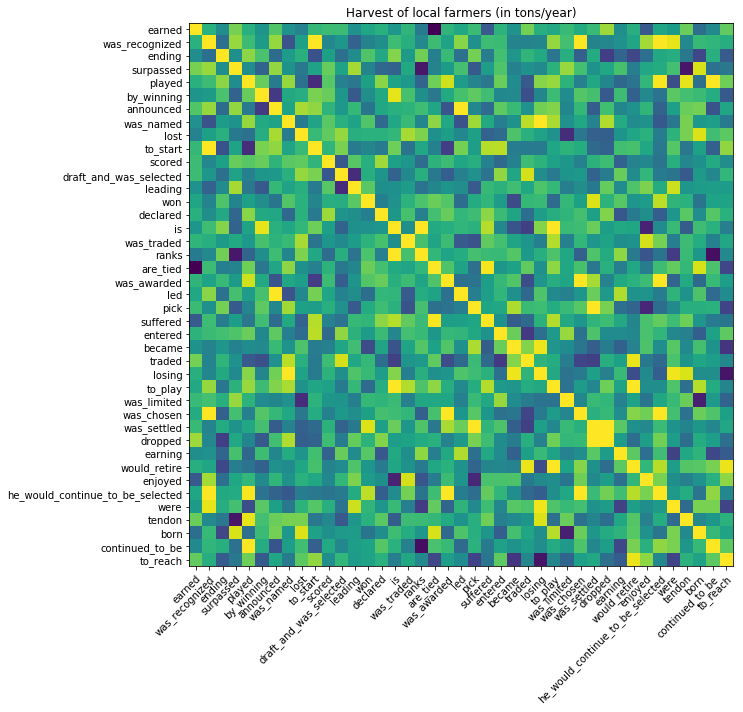

In [39]:
heat_map('data/relation2id.txt', 'data/relation2vec.csv', 0.22)